## Exercises

Import relevant packages

In [1]:
#| code-fold: true
#| code-summary: "Show/hide the code"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calendar import month_abbr
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import urllib.request
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## intra-annual variability

Go to NOAA's National Centers for Environmental Information (NCEI)  
[Climate Data Online: Dataset Discovery](https://www.ncdc.noaa.gov/cdo-web/datasets)

Find station codes in this [map](https://www.ncei.noaa.gov/maps/monthly/). On the left, click on the little wrench (🔧) next to "Global Summary of the Month", then click on "identify" on the panel that just opened, and click on a station (purple circle). You will see the station's name, it's ID, and the period of record. For example, for Ben-Gurion's Airport in Israel:  
BEN GURION, IS  
STATION ID: ISM00040180  
Period of Record: 1951-01-01 to 2020-03-01

You can download **daily** or **monthly** data for each station. Use the function below to download this data to your computer.

In [2]:
#| code-fold: true
#| code-summary: "Show/hide the code"

def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data - uncomment the next 2 lines to make this work
    # urllib.request.urlretrieve(url_daily + station_code + '.csv',
    #                            station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

Now, choose any station with a period of record longer than 30 years, and download its data:  
```python
download_data('BEN_GURION', 'ISM00040180')
```

Load the data into a datafram, and before you continue with the analysis, plot the rainfall data, to see how it looks like.  

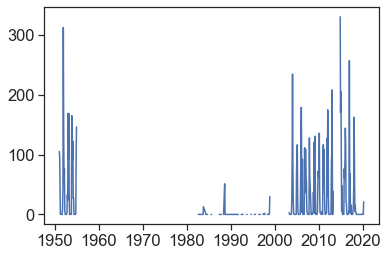

In [3]:
#| code-fold: true
#| code-summary: "Show/hide the code"

download_data('BEN_GURION', 'ISM00040180')
df = pd.read_csv('BEN_GURION_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP'])

It doesn't look great for Ben-Gurion airport, lots of missing data! You might need to choose another station...  Download data for Beer Sheva, ID `IS000051690`.

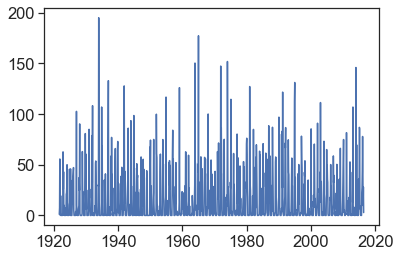

In [4]:
#| code-fold: true
#| code-summary: "Show/hide the code"

download_data('BEER_SHEVA', 'IS000051690')
df = pd.read_csv('BEER_SHEVA_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP'])

That's much better!
We need to aggregate all data from each month, so we can calculate monthly averages. How to do that?

In [5]:
#| code-fold: true
#| code-summary: "Show/hide the code"

# choose only the precipitation column
df_month = df['PRCP']
# calculate monthly mean
monthly_mean = np.array([])  # empty array
month_numbers = np.arange(1,13)
month_names = [month_abbr[i] for i in month_numbers]

for m in month_numbers:      # cycle over months (1, 2, 3, etc)
    this_month_all_indices = (df_month.index.month == m)       # indices in df_month belonging to month m
    this_month_mean = df_month[this_month_all_indices].mean()  # this is the monthly mean
    monthly_mean = np.append(monthly_mean, this_month_mean)    # append

Now it is time to create a new dataframe with the monthly means.

In [6]:
#| code-fold: true
#| code-summary: "Show/hide the code"

df_beersheva = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                             'month names':month_names,
                             'month number':month_numbers
                            })
df_beersheva

,monthly rainfall (mm),month names,month number
0,48.743158,Jan,1
1,37.347368,Feb,2
2,26.551579,Mar,3
3,9.038947,Apr,4
4,2.735789,May,5
5,0.013830,Jun,6
6,0.000000,Jul,7
7,0.002128,Aug,8
8,0.271277,Sep,9
9,6.669474,Oct,10


Plot the data and see if it makes sense. Try to get a figure like this one.

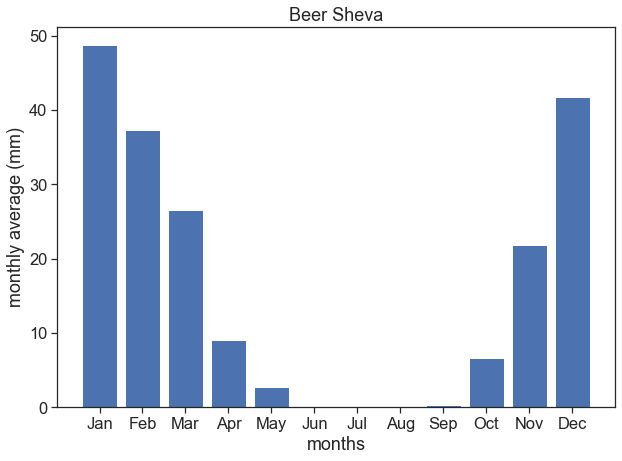

In [7]:
#| code-fold: true
#| code-summary: "Show/hide the code"

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_beersheva['month number'], df_beersheva['monthly rainfall (mm)'])
ax.set(xlabel="months",
       ylabel="monthly average (mm)",
       title="Beer Sheva",
       xticks=df_beersheva['month number'],
       xticklabels=df_beersheva['month names']);
plt.savefig("hydrology_figures/beersheva_monthly_average.png")

Let's calculate now the Walsh and Lawler Seasonality Index.  
**Write a function** that receives a dataframe like the one we have just created, and returns the seasonality index.  
http://leddris.aegean.gr/ses-parameters/293-rainfall-seasonality.html#:~:text=Rainfall%20seasonality%20index%20is%20a,in%20relation%20to%20water%20availability

$R=$ mean annual precipitation  
$m_i$ precipitation mean for month $i$  

$$ SI = \displaystyle \frac{1}{R} \sum_{n=1}^{n=12} \left| m_i - \frac{R}{12} \right| $$

| SI | Precipitation Regime |
| --- | --- |
| <0.19 | Precipitation spread throughout the year |
| 0.20-0.39	 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59	 | Rather seasonal with a short dry season |
| 0.60-0.79	 | Seasonal |
| 0.80-0.99	 | Marked seasonal with a long dry season |
| 1.00-1.19		 | Most precipitation in < 3 months |

In [8]:
#| code-fold: true
#| code-summary: "Show/hide the code"

def walsh_index(df):
    mi = df["monthly rainfall (mm)"]
    R = df["monthly rainfall (mm)"].sum()
    SI = np.sum(np.abs(mi - R/12)) / R
    return SI
beersheva_SI = walsh_index(df_beersheva)
print(f"Beer Sheva, SI = {beersheva_SI:.2f}")

Beer Sheva, SI = 0.97
